# 第13章 Python在金融领域的应用

## 13.1 金融数据准备

In [ ]:
!pip install alpha_vantage

In [2]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
api_key = 'X8MLA34EDFUSK4N1'

In [4]:
ts = TimeSeries(key=api_key, output_format='pandas')

In [5]:
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='compact')
print(data.head())

            1. open   2. high  3. low  4. close   5. volume
date                                                       
2025-02-18   244.15  245.1800  241.84    244.47  48822491.0
2025-02-14   241.25  245.5500  240.99    244.60  40896227.0
2025-02-13   236.91  242.3399  235.57    241.53  53614054.0
2025-02-12   231.20  236.9600  230.68    236.87  45243292.0
2025-02-11   228.20  235.2300  228.13    232.62  53718362.0


下面都是统一为1.31日是最新一天数据的，所以取个巧，读取一下AAPL.csv，取出前100个

In [10]:
data = pd.read_csv('AAPL.csv').head(100)
data.set_index('date',inplace=True)
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-01-31,247.190,247.190,233.44,236.00,101075128.0
2025-01-30,238.665,240.790,237.21,237.59,55658279.0
2025-01-29,234.120,239.855,234.01,239.36,45486100.0
2025-01-28,230.850,240.190,230.81,238.26,75707569.0
2025-01-27,224.020,232.150,223.98,229.86,94863418.0
...,...,...,...,...,...
2024-09-13,223.580,224.040,221.91,222.50,36766619.0
2024-09-12,222.500,223.550,219.82,222.77,37498225.0
2024-09-11,221.455,223.090,217.89,222.66,44587072.0


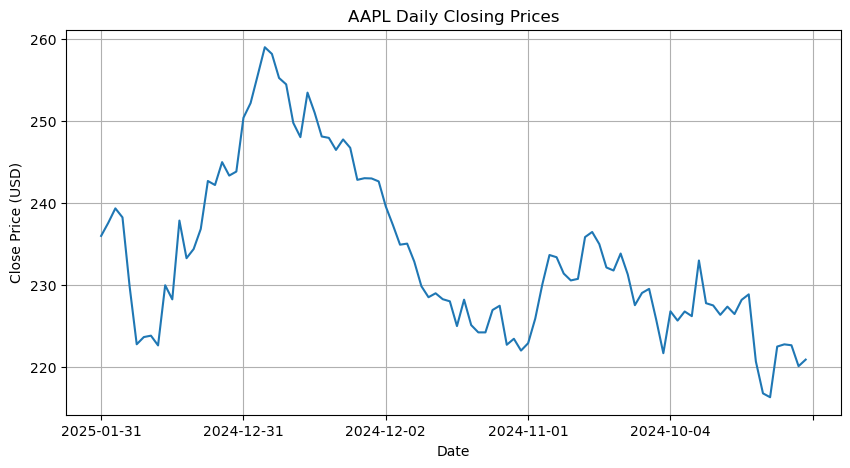

In [12]:
data['4. close'].plot(figsize=(10, 5))
plt.title('AAPL Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid()
plt.savefig('AAPL.svg')
plt.show()

## 13.2 量化交易的利器


### 13.2.2 均线交叉策略实现

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt 
# 读取 CSV 文件 
data = pd.read_csv('AAPL.csv') 
# 查看数据前几行 
data.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-01-31,247.190,247.190,233.44,236.00,101075128.0
1,2025-01-30,238.665,240.790,237.21,237.59,55658279.0
2,2025-01-29,234.120,239.855,234.01,239.36,45486100.0
3,2025-01-28,230.850,240.190,230.81,238.26,75707569.0
4,2025-01-27,224.020,232.150,223.98,229.86,94863418.0


In [16]:
# 取最近 600 条数据，并确保按时间升序排列
data = data.sort_index(ascending=True).iloc[:600]
# 转换 "date" 列为日期格式
data["date"] = pd.to_datetime(data["date"])
# 按日期升序排序，确保数据顺序正确
data.sort_values(by="date", ascending=True, inplace=True)
data.head()

,date,1. open,2. high,3. low,4. close,5. volume
599,2022-09-12,159.590,164.26,159.3000,163.43,104955962.0
598,2022-09-13,159.900,160.54,153.3700,153.84,122656614.0
597,2022-09-14,154.785,157.10,153.6106,155.31,87965409.0
596,2022-09-15,154.650,155.24,151.3800,152.37,90481110.0
595,2022-09-16,151.210,151.35,148.3700,150.70,162278841.0


In [17]:
# 计算 50 日和 200 日移动均线
data["MA50"] = data["4. close"].rolling(window=50).mean()
data["MA200"] = data["4. close"].rolling(window=200).mean()

In [18]:
# 生成交易信号
data["Signal"] = 0
data.loc[data["MA50"] > data["MA200"], "Signal"] = 1
data.loc[data["MA50"] < data["MA200"], "Signal"] = -1

In [19]:
# 识别买入点（短期均线上穿长期均线）
cross_up = data[data["Signal"].diff() == 2]
# 识别卖出点（短期均线下穿长期均线）
cross_down = data[data["Signal"].diff() == -2]

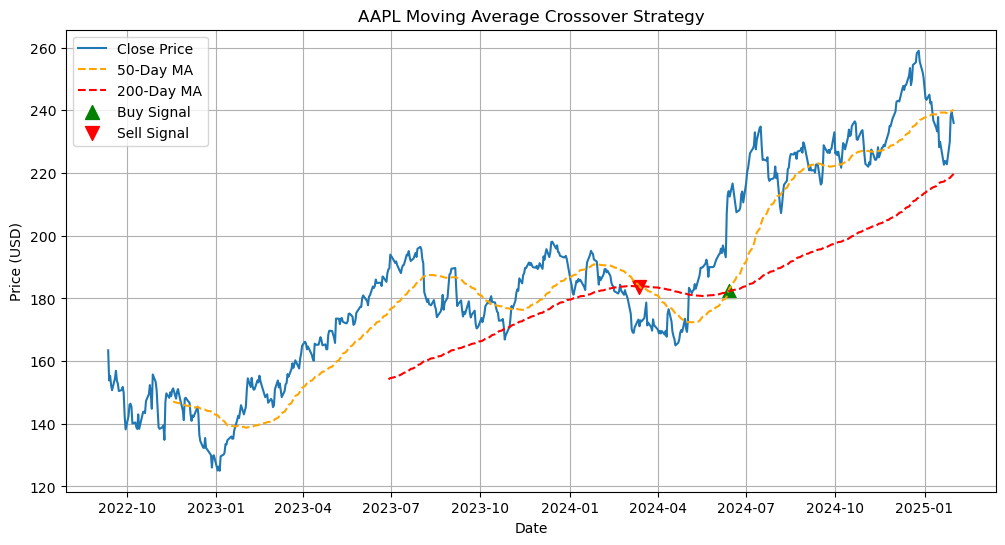

In [20]:
# 绘制收盘价及均线
plt.figure(figsize=(12,6))
plt.plot(data["date"], data["4. close"], label="Close Price")
plt.plot(data["date"], data["MA50"], label="50-Day MA", linestyle="--", color="orange")
plt.plot(data["date"], data["MA200"], label="200-Day MA", linestyle="--", color="red")

# 标注买卖点
plt.scatter(cross_up["date"], cross_up["MA50"], marker="^", color="g", s=100, label="Buy Signal")  # 绿色向上箭头
plt.scatter(cross_down["date"], cross_down["MA50"], marker="v", color="r", s=100, label="Sell Signal")  # 红色向下箭头

# 设置标题和标签
plt.title("AAPL Moving Average Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

### 13.2.3 Python量化交易库

In [23]:
!pip install pyti

In [70]:
import pandas as pd
import numpy as np

data = pd.read_csv('AAPL.csv')
#确保按最新时间取最近600个样本
data = data.sort_index(ascending=True).iloc[:600]  

In [71]:
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.exponential_moving_average import exponential_moving_average as ema

# 计算 RSI（14 天）
data["RSI"] = rsi(data["4. close"].tolist(), 14)

# 计算 MACD 指标
data["MACD"] = ema(data["4. close"].tolist(), 12) - ema(data["4. close"].tolist(), 26)
data["MACD_signal"] = ema(data["MACD"].tolist(), 9)
data["MACD_hist"] = data["MACD"] - data["MACD_signal"]

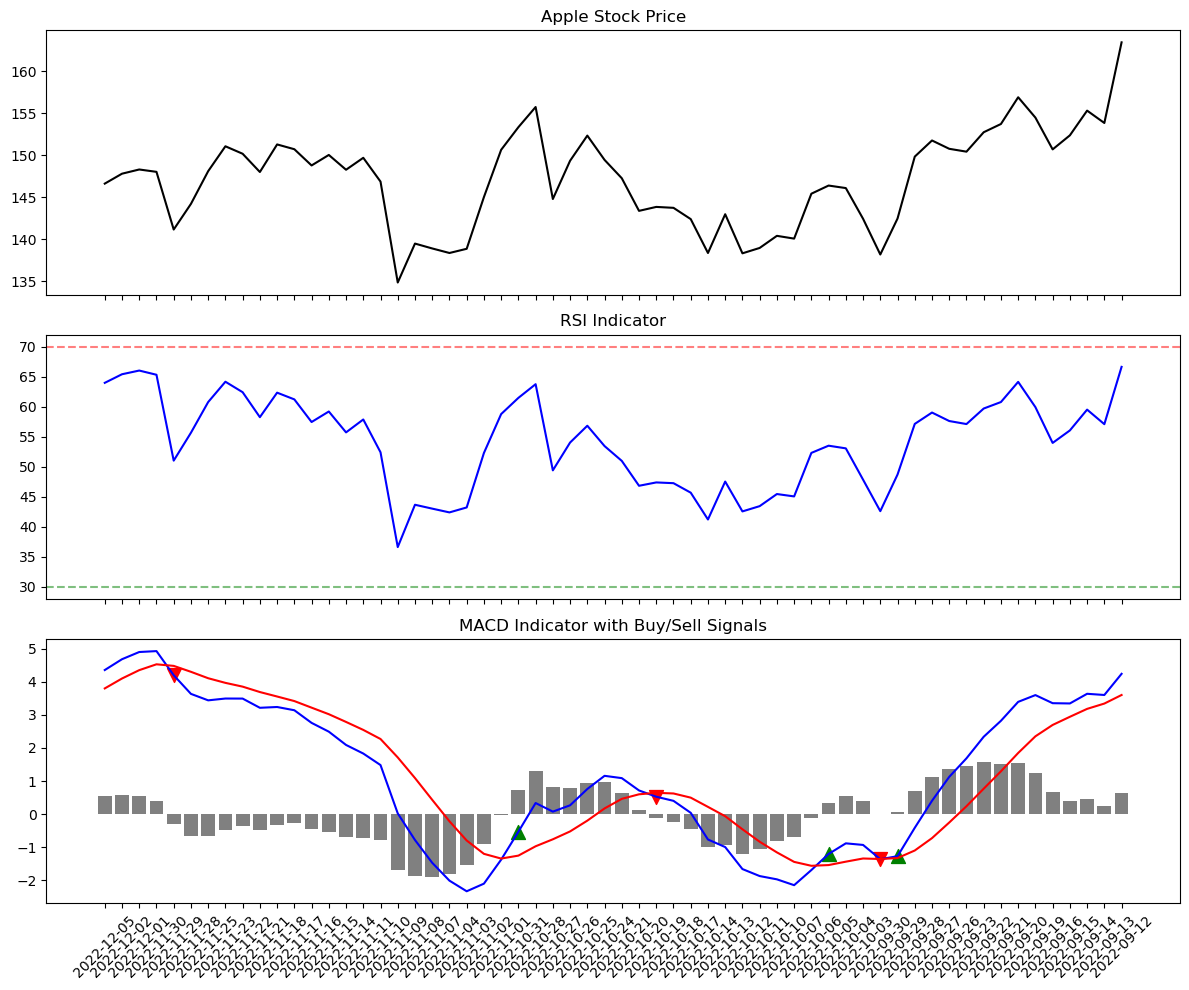

In [72]:
import matplotlib.pyplot as plt

# 选取最近 60 天数据
data_vis = data.tail(60)

# 创建子图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1️⃣ 价格走势图
ax1.plot(data_vis["date"], data_vis["4. close"], color="black")
ax1.set_title("Apple Stock Price")

# 2️⃣ RSI 指标
ax2.plot(data_vis["date"], data_vis["RSI"], color="blue")
ax2.axhline(70, linestyle="--", color="red", alpha=0.5)
ax2.axhline(30, linestyle="--", color="green", alpha=0.5)
ax2.set_title("RSI Indicator")

# 3️⃣ MACD 指标
ax3.plot(data_vis["date"], data_vis["MACD"], color="blue")
ax3.plot(data_vis["date"], data_vis["MACD_signal"], color="red")
ax3.bar(data_vis["date"], data_vis["MACD_hist"], color="gray")

# 标记 MACD 金叉 & 死叉
buy_signals = data_vis[
    (data_vis["MACD"] > data_vis["MACD_signal"]) & 
    (data_vis["MACD"].shift(1) <= data_vis["MACD_signal"].shift(1))
]
sell_signals = data_vis[
    (data_vis["MACD"] < data_vis["MACD_signal"]) & 
    (data_vis["MACD"].shift(1) >= data_vis["MACD_signal"].shift(1))
]

ax3.scatter(buy_signals["date"], buy_signals["MACD"], color="green", marker="^", s=100)
ax3.scatter(sell_signals["date"], sell_signals["MACD"], color="red", marker="v", s=100)
ax3.set_title("MACD Indicator with Buy/Sell Signals")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [67]:
!pip install bt

In [73]:
data

,date,1. open,2. high,3. low,4. close,5. volume,RSI,MACD,MACD_signal,MACD_hist
0,2025-01-31,247.190,247.190,233.4400,236.00,101075128.0,NaN,NaN,NaN,NaN
1,2025-01-30,238.665,240.790,237.2100,237.59,55658279.0,NaN,NaN,NaN,NaN
2,2025-01-29,234.120,239.855,234.0100,239.36,45486100.0,NaN,NaN,NaN,NaN
3,2025-01-28,230.850,240.190,230.8100,238.26,75707569.0,NaN,NaN,NaN,NaN
4,2025-01-27,224.020,232.150,223.9800,229.86,94863418.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
595,2022-09-16,151.210,151.350,148.3700,150.70,162278841.0,53.978728,3.352503,2.695289,0.657214
596,2022-09-15,154.650,155.240,151.3800,152.37,90481110.0,56.057207,3.344551,2.941598,0.402953
597,2022-09-14,154.785,157.100,153.6106,155.31,87965409.0,59.523061,3.636474,3.180795,0.455679
598,2022-09-13,159.900,160.540,153.3700,153.84,122656614.0,57.098131,3.600351,3.341387,0.258964


**我这里保存了一份，用MACD去做回测的代码，关键是读取数据的时候要以date为索引，也就是第一行！不然做出来结果容易出错**

100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

Stat                 MACD Strategy
-------------------  ---------------
Start                2022-09-11
End                  2025-01-31
Risk-free rate       0.00%

Total Return         34.17%
Daily Sharpe         0.90
Daily Sortino        1.46
CAGR                 13.08%
Max Drawdown         -15.10%
Calmar Ratio         0.87

MTD                  -0.95%
3m                   6.23%
6m                   5.05%
YTD                  -0.95%
1Y                   9.33%
3Y (ann.)            13.08%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  13.08%

Daily Sharpe         0.90
Daily Sortino        1.46
Daily Mean (ann.)    13.45%
Daily Vol (ann.)     14.88%
Daily Skew           0.77
Daily Kurt           12.14
Best Day             7.56%
Worst Day            -4.24%

Monthly Sharpe       0.78
Monthly Sortino      1.40
Monthly Mean (ann.)  14.28%
Monthly Vol (ann.)   18.27%
Monthly Skew         -0.48
Monthly Kurt         1.21
Best Month           11.32%
Worst Month          -13.7

<Axes: title={'center': 'Equity Progression'}>

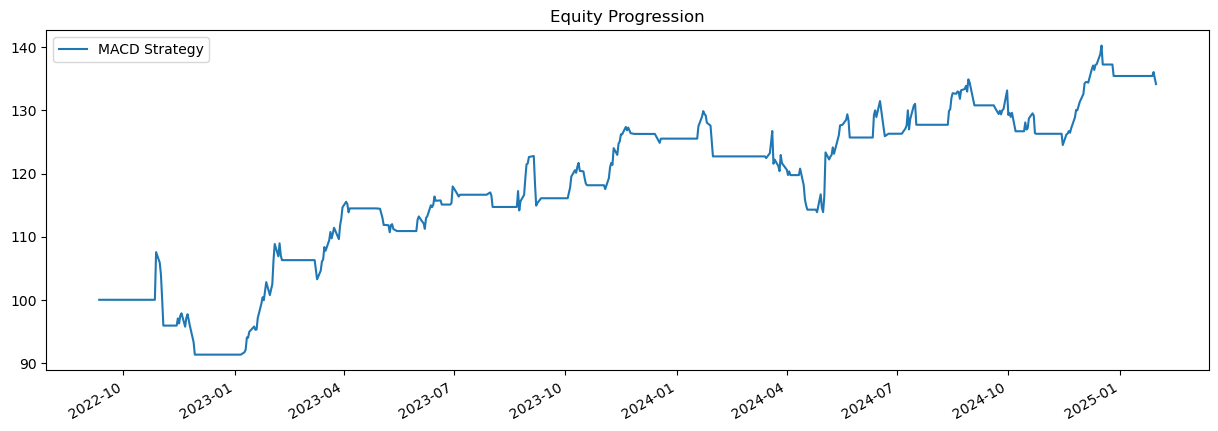

In [80]:
import pandas as pd
import numpy as np
import bt
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.exponential_moving_average import exponential_moving_average as ema

# 1. 读取数据，并确保 Date 为索引
data = pd.read_csv('AAPL.csv', parse_dates=['date'], index_col='date')
data = data.sort_index(ascending=True)

# 选取最近600个样本（注意：这里假设数据按时间正序排列，
# 如果 CSV 中数据顺序不同，请根据需要调整）
recent_data = data.iloc[-600:].copy()

# 2. 计算技术指标
# 计算 RSI (14 天)，这里仅供参考
recent_data["RSI"] = rsi(recent_data["4. close"].tolist(), 14)

# 计算 MACD 及其信号线和柱状图
recent_data["MACD"] = ema(recent_data["4. close"].tolist(), 12) - ema(recent_data["4. close"].tolist(), 26)
recent_data["MACD_signal"] = ema(recent_data["MACD"].tolist(), 9)
recent_data["MACD_hist"] = recent_data["MACD"] - recent_data["MACD_signal"]

# 3. 根据 MACD 生成交易信号：
# 当 MACD > MACD_signal 时，信号为 1（全仓做多），否则为 0（空仓）。
recent_data["Signal"] = np.where(recent_data["MACD"] > recent_data["MACD_signal"], 1, 0)

# 将收盘价构造成 bt 回测所需的价格 DataFrame（列名为资产代码，比如 'AAPL'）
prices = recent_data["4. close"].to_frame(name='AAPL')

# 提取信号序列（index 与 prices 对齐）
signal_series = recent_data["Signal"]

# 4. 定义一个自定义 Algo，根据当天的信号设置目标仓位
def macd_signal_target(target):
    # 当前日期
    dt = target.now
    # 如果当前日期在信号序列中，则获取对应信号，否则认为信号为0（空仓）
    if dt in signal_series.index:
        weight = signal_series.loc[dt]
    else:
        weight = 0
    # 将资产 'AAPL' 的仓位设置为信号值（1 表示全仓，0 表示空仓）
    target.temp['weights'] = {'AAPL': weight}
    return True

# 定义策略：每天运行，根据 macd_signal_target 调整仓位，然后执行再平衡
strategy = bt.Strategy('MACD Strategy',
                       [bt.algos.RunDaily(),
                        macd_signal_target,
                        bt.algos.Rebalance()])

# 5. 构造回测并运行
backtest = bt.Backtest(strategy, prices)
result = bt.run(backtest)

# 输出回测结果报告
print(result.display())

# 绘制回测净值曲线
result.plot()


**下面给的是均线的最基本的回测，也可以，展示一下基本方法，把MACD的留到课后习题**

In [28]:
import bt
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('AAPL.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [31]:
#选取收盘价数据用于回测 
price_data = df[['4. close']].copy() # 只保留收盘价 

#计算 20 日均线 
df['ma20'] = df['4. close'].rolling(window=20).mean() 

# 生成交易信号（True=持仓，False=空仓） 
df['signal_raw'] = df['4. close'] > df['ma20']

# 让信号与 price_data 保持一致 
signal_df = df[['signal_raw']].copy() 
signal_df.columns = ['4. close'] # 需要与 price_data 结构相同 
signal_df = signal_df.reindex(price_data.index, method='ffill') # 处理数据对齐问题

In [32]:
strategy = bt.Strategy(
 'AboveMA20',
 [ 
bt.algos.SelectWhere(signal_df), # 选取持仓信号 
bt.algos.WeighEqually(), # 资金等权分配（单资产即全仓）
bt.algos.Rebalance() # 每日执行买卖 
] 
)

100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


Stat                 AboveMA20
-------------------  -----------
Start                1999-10-31
End                  2025-01-31
Risk-free rate       0.00%

Total Return         27.62%
Daily Sharpe         0.33
Daily Sortino        0.40
CAGR                 0.97%
Max Drawdown         -88.40%
Calmar Ratio         0.01

MTD                  -3.55%
3m                   5.93%
6m                   4.37%
YTD                  -3.55%
1Y                   18.83%
3Y (ann.)            14.53%
5Y (ann.)            -1.20%
10Y (ann.)           11.54%
Since Incep. (ann.)  0.97%

Daily Sharpe         0.33
Daily Sortino        0.40
Daily Mean (ann.)    12.16%
Daily Vol (ann.)     36.36%
Daily Skew           -16.18
Daily Kurt           538.32
Best Day             13.69%
Worst Day            -85.47%

Monthly Sharpe       0.32
Monthly Sortino      0.45
Monthly Mean (ann.)  12.01%
Monthly Vol (ann.)   37.97%
Monthly Skew         -2.42
Monthly Kurt         19.68
Best Month           45.29%
Worst Month        

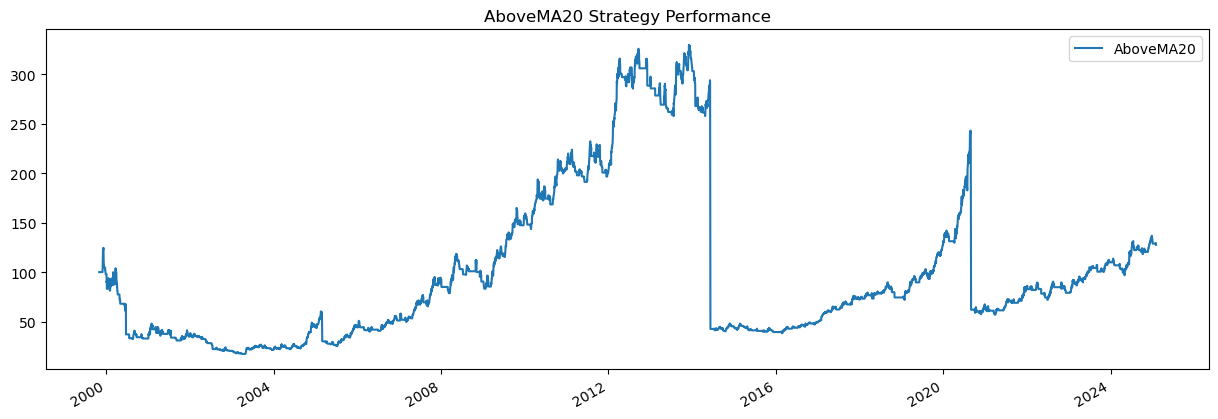

In [33]:
# 创建回测并运行
bt_test = bt.Backtest(strategy, price_data)
res = bt.run(bt_test)

# 查看回测结果
res.display()  # 主要统计指标
res.plot(title='AboveMA20 Strategy Performance')
plt.show()

## 13.3 金融资产组合优化的量化分析


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
num_assets = 3
# 读取数据
file_path = "group.csv"  # 请确保该文件包含三只股票的收盘价数据
data = pd.read_csv(file_path)

# 设定日期列为索引
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])  # 确保日期格式正确
    data.set_index('date', inplace=True)

In [35]:
# 计算每日收益率
returns = data.pct_change().dropna()

In [36]:
# 计算年化收益率和协方差矩阵
trading_days = len(returns)  # 数据集中的交易天数
annual_factor = trading_days / (data.shape[0] / 252)  # 动态年化因子
mean_returns = returns.mean() * annual_factor  # 年化收益率
cov_matrix = returns.cov() * 252  # 年化协方差矩阵

In [37]:
# 计算投资组合的波动率（标准差）
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [39]:
# 约束条件：权重之和为1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# 权重范围：[0,1]，即不允许做空
bounds = tuple((0, 1) for _ in range(num_assets))

# 初始权重：均匀分配
init_weights = np.array([1.0 / num_assets] * num_assets)

# 最优化求解最小波动率组合
result = minimize(portfolio_volatility, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)
optimal_weights = result.x

# 计算最优组合的年化收益率和风险
optimal_return = np.sum(optimal_weights * mean_returns)
optimal_risk = portfolio_volatility(optimal_weights) 
print(optimal_return)
print(optimal_risk)
print(optimal_weights)

0.1439485504585505
0.24969372895691147
[0.52743848 0.46961832 0.00294319]


In [40]:
# 目标收益率（设定一个目标，例如年化10%）
target_return = 0.1

# 约束条件：1. 权重之和等于1  2. 组合的期望收益率等于目标值
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 权重总和为1
    {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - target_return}  # 组合收益率 = 目标收益
)

# 优化求解
result = minimize(portfolio_volatility, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)

# 获取最优权重
optimal_weights_mvo = result.x

optimal_risks_mvo = portfolio_volatility(optimal_weights_mvo)

In [41]:
print(optimal_risks_mvo)
print(optimal_weights_mvo)

0.2669961657977519
[0.46578754 0.3719957  0.16221676]


new try: MACD的回测